In [1]:
from IPython.display import display
import spot
spot.setup(show_default='.bans')

This notebook demonstrates how to use the `decompose_scc()` function to split an automaton in up to three automata capturing different behaviors.   This is based on the paper [Strength-based decomposition of the property Büchi automaton for faster model checking](https://www.lrde.epita.fr/~adl/dl/adl/renault.13.tacas.pdf) (TACAS'13).

This page uses the Python bindings, but the same decompositions can be performed from the shell using [`autfilt`](https://spot.lrde.epita.fr/autfilt.html) and its `--decompose-scc` option.

# Basics

Let's define the following strengths of accepting SCCs:

- an accepting SCC is **inherently weak** if it does not contain any rejecting cycle
- an accepting SCC is **inherently terminal** if it is *inherently weak* and complete (i.e. from any state, you can stay in the SCC by reading any word)
- an accepting SCC is **strictly inherently weak** if it is *inherently weak* and not complete (in other words: *weak* but not *terminal*)
- an accepting SCC is **strong** if it is not inherently weak.

The strengths **strong**, **stricly inherently weak**, and **inherently terminal** define a partition of all accepting SCCs.  The following Büchi automaton has 4 SCCs, and its 3 accepting SCCs show an example of each strength.

Note: the reason we use the word *inherently* is that the *weak* and *terminal* properties are usually defined syntactically: an accepting SCC would be weak if all its transitions belong to the same acceptance sets.  This syntactic criterion is a sufficient condition for an accepting SCC to not have any rejecting cycle, but it is not necessary.  Hence a *weak* SCC is *inherently weak*; but while an *inherently weak* SCC is not necessarily *weak*, it can be modified to be *weak* without alterning the langage.

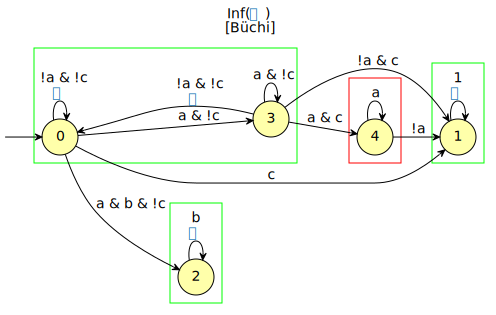

In [2]:
aut = spot.translate('(Ga -> Gb) W c')
aut

The `decompose_strength()` function takes an automaton, and a string specifying which strength to preserve.  

The letters used for this specification are as follows:

- `t`: (inherently) terminal
- `w`: (strictly inherently) weak
- `s`: strong

For instance if we want to preserve only the **strictly inherently weak** part of this automaton, we should get only the SCC with the self-loop on $b$, and the SCC above it so that we can reach it.  However the SCC above is not stricly weak, so it should not accept any word in the new automaton.

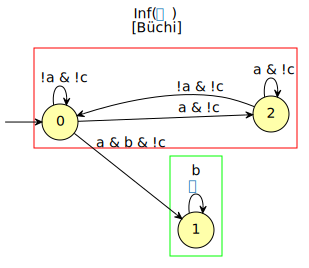

In [3]:
spot.decompose_scc(aut, 'w')

Similarly, we can extract all the behaviors captured by the **inherently terminal** part of the automaton:

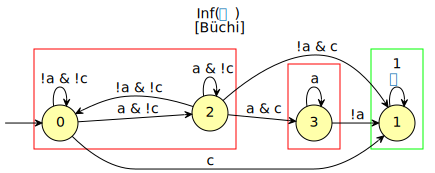

In [4]:
spot.decompose_scc(aut, 't')

Here is the **strong** part:

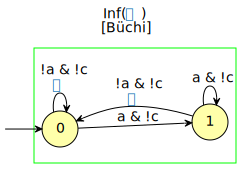

In [5]:
strong = spot.decompose_scc(aut, 's'); strong

The union of these three automata recognize the same language as the original automaton.


The application proposed in the aforementioned TACAS'13 paper is for parallelizing model checking.  Instead of testing the emptiness of the product between `aut` and a system, one could test the emptiness **3** products in parallel: each with a sub-automaton of different strength.  Model checking using weak and terminal automata can be done with much more simpler emptiness check procedures than needed for the general case.  So in effect, we have isolated the "hard" (i.e. strong) part of the original automaton in a smaller automaton, and we only need to use a full-fledged emptiness check for this case.

An additional bonus is that it is possible that the simplification algorithms will do a better job at simplifying the sub-automata than at simplifying the original `aut`.  For instance here the `strong` automaton can be further simplified:

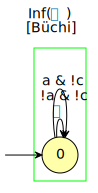

In [6]:
strong.postprocess('small')

# Multi-strength extraction

The string passed to `decompose_strength()` can include multiple letters to extract multiple strengths at once.

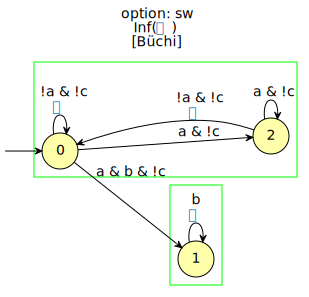

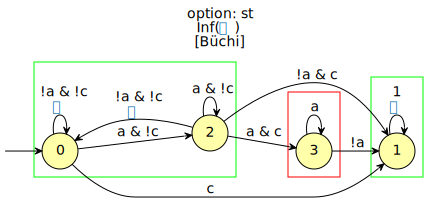

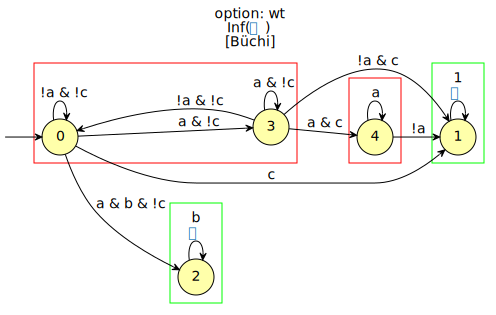

In [7]:
for opt in ('sw', 'st', 'wt'):
    a = spot.decompose_scc(aut, opt)
    a.set_name("option: " + opt)
    display(a)

# Generalized acceptance

There is nothing that prevents the above decomposition to work with other types of acceptance.

## Rabin

The following Rabin automaton was generated with

    ltldo -f '(Ga -> Gb) W c' 'ltl2dstar --ltl2nba=spin:ltl2tgba@-Ds' -H | autfilt -H --merge-transitions
    
(The `autfilt -H --merge-transitions` pass is just here to reduce the size of the file and make the automaton more readable.)

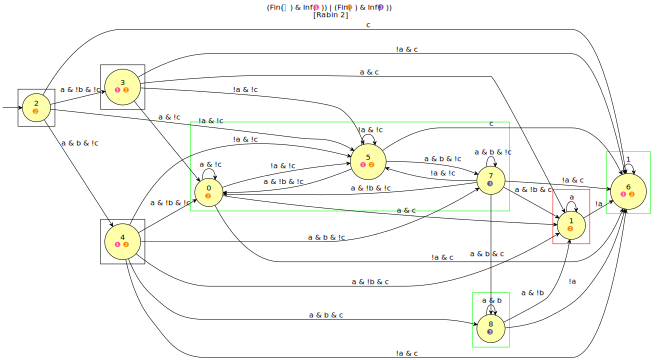

In [8]:
aut = spot.automaton("""
HOA: v1
States: 9
Start: 2
AP: 3 "a" "b" "c"
acc-name: Rabin 2
Acceptance: 4 (Fin(0) & Inf(1)) | (Fin(2) & Inf(3))
properties: trans-labels explicit-labels state-acc complete
properties: deterministic
--BODY--
State: 0 {2}
[0&!2] 0
[0&2] 1
[!0&!2] 5
[!0&2] 6
State: 1 {2}
[0] 1
[!0] 6
State: 2 {2}
[0&!1&!2] 3
[0&1&!2] 4
[!0&!2] 5
[2] 6
State: 3 {1 2}
[0&!2] 0
[0&2] 1
[!0&!2] 5
[!0&2] 6
State: 4 {1 2}
[0&!1&!2] 0
[0&!1&2] 1
[!0&!2] 5
[!0&2] 6
[0&1&!2] 7
[0&1&2] 8
State: 5 {1 2}
[0&!1&!2] 0
[!0&!2] 5
[2] 6
[0&1&!2] 7
State: 6 {1 2}
[t] 6
State: 7 {3}
[0&!1&!2] 0
[0&!1&2] 1
[!0&!2] 5
[!0&2] 6
[0&1&!2] 7
[0&1&2] 8
State: 8 {3}
[0&!1] 1
[!0] 6
[0&1] 8
--END--
""")
aut

Let's decompose it into three strengths:

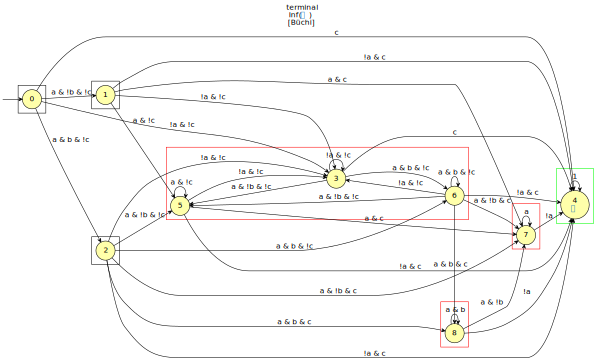

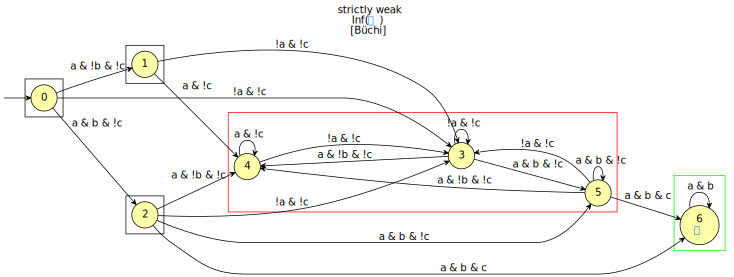

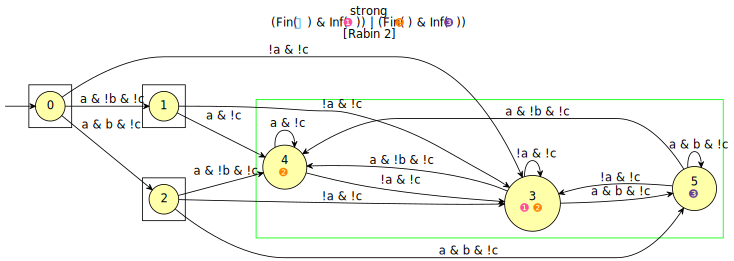

In [9]:
for (name, opt) in (('terminal', 't'), ('strictly weak', 'w'), ('strong', 's')):
    a = spot.decompose_scc(aut, opt)
    a.set_name(name)
    display(a)

Note how the two weak automata (i.e., stricly weak and terminal) are now using a Büchi acceptance condition (because that is sufficient for weak automata) while the strong automaton inherited the original acceptance condition.

When extracting multiple strengths and one of the strength is **strong**, we preserve the original acceptance.  For instance extracting **strong** and **inherently terminal** gives the following automaton, where only **stricly inherently weak** SCCs have become rejecting.

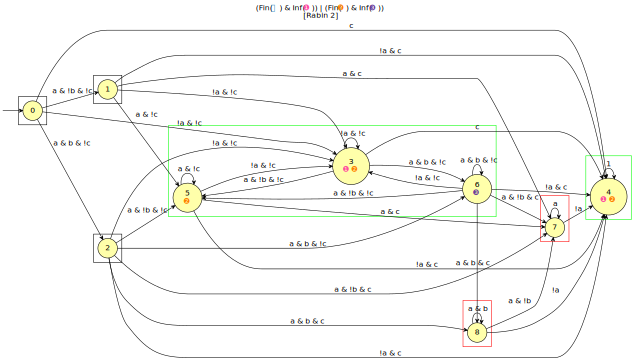

In [10]:
spot.decompose_scc(aut, "st")

The weak automata seem to be good candidates for further simplification.  Let's add a call to `postprocess()` to our decomposition loop, trying to preserve the determinism and state-based acceptance of the original automaton.

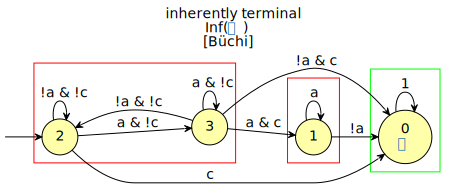

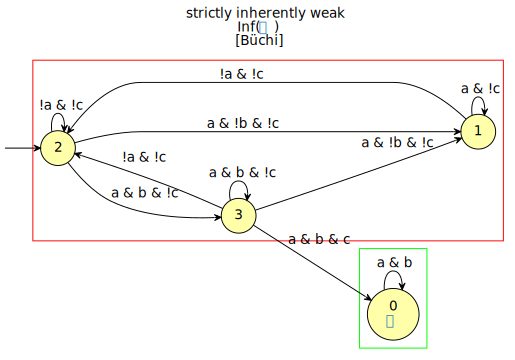

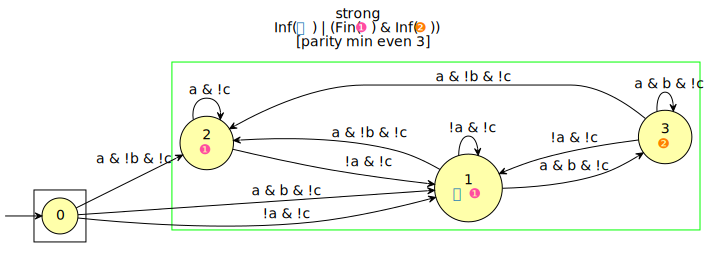

In [11]:
for (name, opt) in (('inherently terminal', 't'), ('strictly inherently weak', 'w'), ('strong', 's')):
    a = spot.decompose_scc(aut, opt).postprocess('deterministic', 'SBAcc')
    a.set_name(name)
    display(a)

## Streett

Since this notebook also serves as a test suite, let's try a Streett automaton.  This one was generated with

    ltldo -f '(Ga -> Gb) W c' 'ltl2dstar --automata=streett --ltl2nba=spin:ltl2tgba@-Ds' -H | 
    autfilt -H --merge-transitions

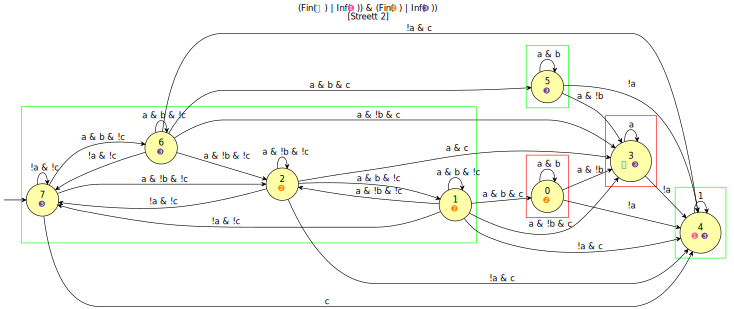

In [12]:
aut = spot.automaton("""
HOA: v1
States: 8
Start: 7
AP: 3 "a" "b" "c"
acc-name: Streett 2
Acceptance: 4 (Fin(0) | Inf(1)) & (Fin(2) | Inf(3))
properties: trans-labels explicit-labels state-acc complete
properties: deterministic
--BODY--
State: 0 {2}
[0&1] 0
[0&!1] 3
[!0] 4
State: 1 {2}
[0&1&2] 0
[0&1&!2] 1
[0&!1&!2] 2
[0&!1&2] 3
[!0&2] 4
[!0&!2] 7
State: 2 {2}
[0&1&!2] 1
[0&!1&!2] 2
[0&2] 3
[!0&2] 4
[!0&!2] 7
State: 3 {0 3}
[0] 3
[!0] 4
State: 4 {1 3}
[t] 4
State: 5 {3}
[0&!1] 3
[!0] 4
[0&1] 5
State: 6 {3}
[0&!1&!2] 2
[0&!1&2] 3
[!0&2] 4
[0&1&2] 5
[0&1&!2] 6
[!0&!2] 7
State: 7 {3}
[0&!1&!2] 2
[2] 4
[0&1&!2] 6
[!0&!2] 7
--END--
""")
aut

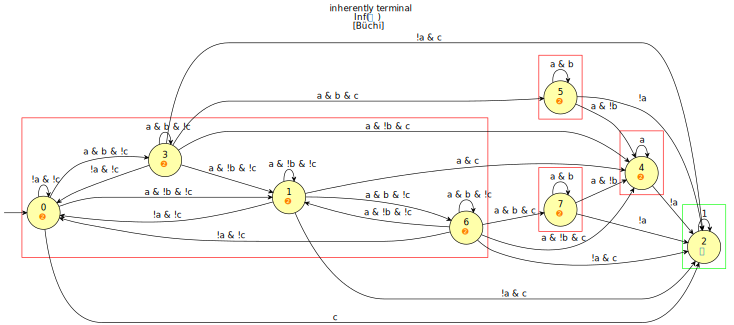

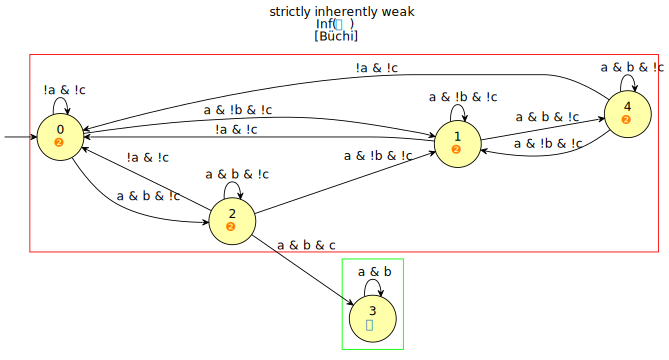

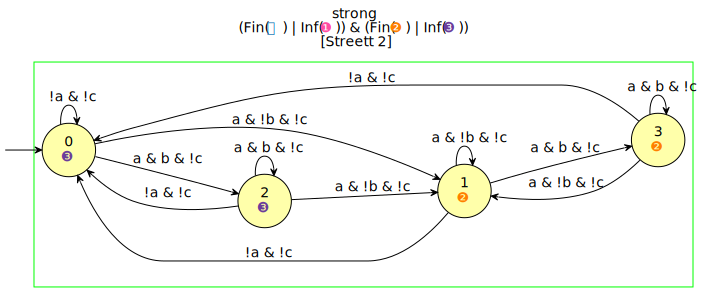

In [13]:
for (name, opt) in (('inherently terminal', 't'), ('strictly inherently weak', 'w'), ('strong', 's')):
    a = spot.decompose_strength(aut, opt)
    a.set_name(name)
    display(a)

The subtlety of Streett acceptance is that if a path that does not visit any accepting set infinitely often *is* accepting.  So when disabling SCCs, we must be careful to label them with a combination of rejecting acceptance sets.

This is easy to understand using an example.  In the following extraction of the **strong** and **inherently terminal** parts, the rejecting SCCs (that were either rejecting or strictly inherently weak originally) have been labeled by the same acceptance sets, to ensure that they are rejected.

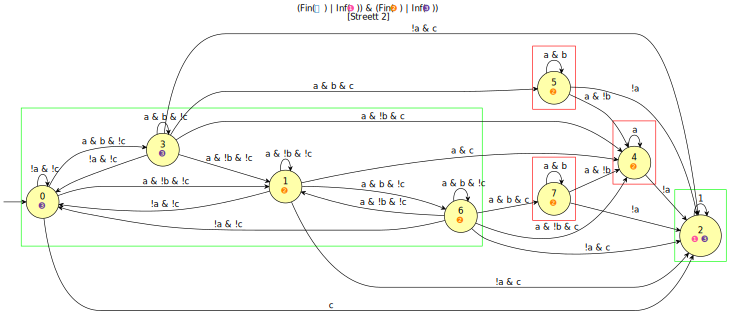

In [14]:
spot.decompose_scc(aut, 'st')

## Corner cases

When the acceptance condition is always satisfiable, all non-trivial SCCs are accepting, and inherently weak.

This include acceptances like `Acceptance: 0 t`, but also trickier ones like `Acceptance: 1 Inf(0) | Fin(0)` that you can make as complex as you fancy.

###  `Acceptance: 0 t`

This occur frequently whant translating LTL formulas that are safety properties:

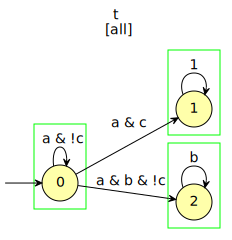

In [15]:
aut = spot.translate('(Gb|c) R a', 'any'); aut

In [16]:
# There is no strong part for this automaton
assert spot.decompose_scc(aut, 's') is None

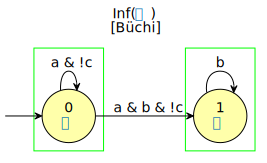

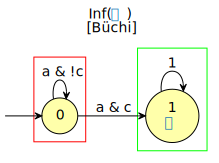

In [17]:
for opt in ('w', 't'):
    display(spot.decompose_scc(aut, opt))

If we try to extract multiple strengths and include the (empty) strong part, this request will simply be ignored:

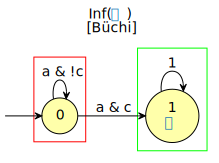

In [18]:
spot.decompose_scc(aut, 'st')

Note that the above is exactly the output of `decompose_strength(aut, 't')`. The `'s'` flag was actively ignored.  If `'s'` had not been ignored an the automaton processed as if its strong part had to be preserved, the original acceptance conditions would have been used, and this would have prevented the disabling of the initial SCC.

### `Acceptance: 1 Inf(0) | Fin(0)`

This acceptance could be replaced by `Acceptance: 0 t` without altering the language of the automaton.  However its use of acceptance sets allows us to define some automata with SCCs that are *inherently weak* but not *weak*.

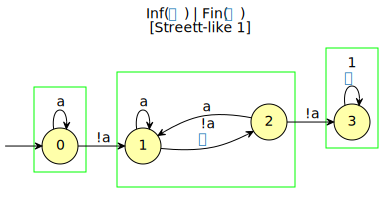

In [19]:
aut = spot.automaton("""
HOA: v1
States: 4
Start: 0
AP: 1 "a"
Acceptance: 1 Inf(0) | Fin(0)
--BODY--
State: 0
[0] 0 
[!0] 1
State: 1
[0] 1 
[!0] 2 {0}
State: 2
[0] 1
[!0] 3
State: 3
[t] 3 {0}
--END--
""")
aut

By our definitions, SCC $\{0\}$ and $\{1,2\}$ are inherently weak, and SCC $\{3\}$ is terminal.

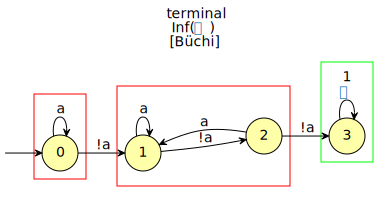

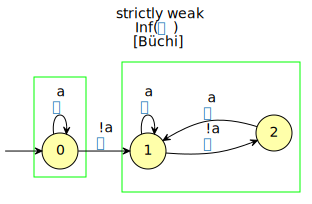

no output for strong


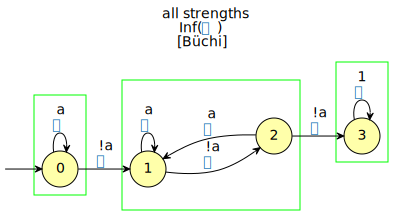

In [20]:
for (name, opt) in (('terminal', 't'), ('strictly weak', 'w'), ('strong', 's'), ('all strengths', 'swt')):
    a = spot.decompose_scc(aut, opt)
    if a:
        a.set_name(name)
        display(a)
    else:
        print("no output for " + name)

# `decompose_scc()` by SCC number

Decompose SCC can also be called by SCC numbers.
The example below show the different SCC numbers and the state they contains, before extracting the sub-automaton containing SCC 0 and 2 (i.e., anything leading to states 1 and 4 of the original automaton).  This example also shows that when an `scc_info` is available for to automaton to decompose, it can be passed to `decompose_scc()` in lieu of the automaton: doing so is faster because `decompose_scc()` does not need to rebuild this object. 

SCC #0 contains states [1]
SCC #1 contains states [2]
SCC #2 contains states [4]
SCC #3 contains states [0, 3]


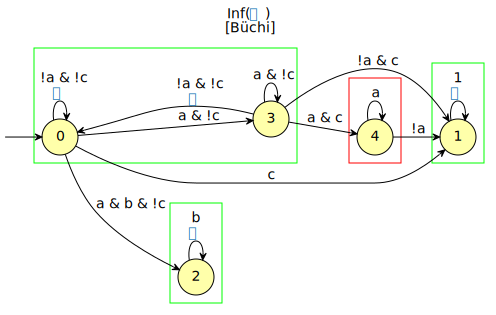

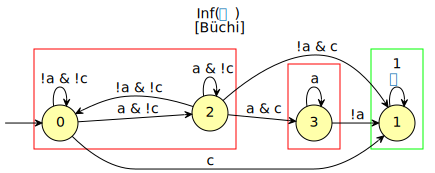

In [21]:
aut = spot.translate('(Ga -> Gb) W c')
si = spot.scc_info(aut)
for scc in range(si.scc_count()):
    print("SCC #{} contains states {}".format(scc, list(si.states_of(scc))))
display(aut)
spot.decompose_scc(si, '0,2')

If an SCC number N is prefixed by `a`, it signifies that we want to extract the Nth *accepting* SCC.  In the above example SCC 2 is rejecting so SCC `a2` denotes SCC 3.

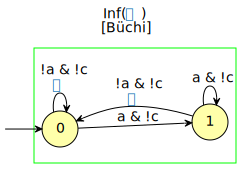

In [22]:
spot.decompose_scc(si, 'a2')